#### Notebook setup and imports

In addition to matplotlib and numpy, we will use the `dysts` library for some utilities, and the `degas` library for custom plotting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Turn on autoreload
%load_ext autoreload

def smape_rolling(ts1, ts2):
    """Return the smape versus time for two time series."""
    n = min(ts1.shape[0], ts2.shape[0])
    all_smape = list()
    for i in range(n):
        smape_val = smape(ts1[:i], ts2[:i])
        all_smape.append(smape_val)
    return np.array(all_smape)


# Plot single system results

In [39]:
from dysts.metrics import smape

equation_name = "Lorenz"
# equation_name = "Chua"

all_scores = dict()
traj_test_forecast = np.load(f"/Users/william/program_repos/dysts_data/benchmark_results/zero-shot/forecast_{equation_name}_true_chronos.npy", allow_pickle=True)
for model_size in ["tiny", "mini", "small", "base", "large"]:
    all_traj_forecasts = np.load(
        f"/Users/william/program_repos/dysts_data/benchmark_results/zero-shot/forecast_{equation_name}_chronos-{model_size}-context100.npy", allow_pickle=True
    )
    all_smape_rolling = list()
    for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
        all_smape = list()
        for i in range(traj_pred.shape[1]):
            smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
            # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
            all_smape.append(smape_val)
        all_smape_rolling.append(all_smape)
    all_smape_rolling = np.array(all_smape_rolling)
    all_scores[model_size] = np.copy(all_smape_rolling)

/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/3047974770.py:16: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


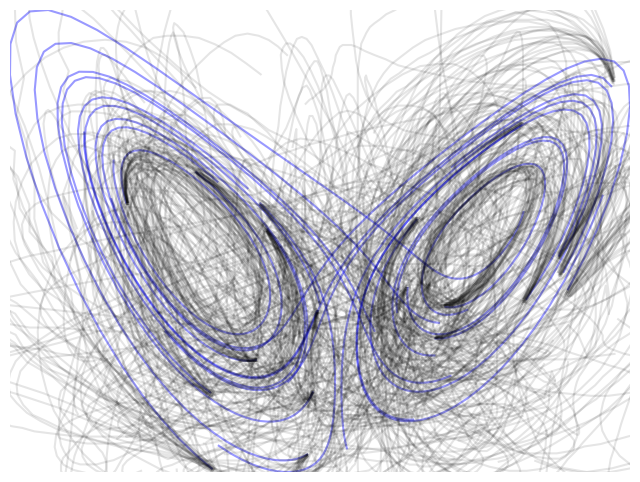

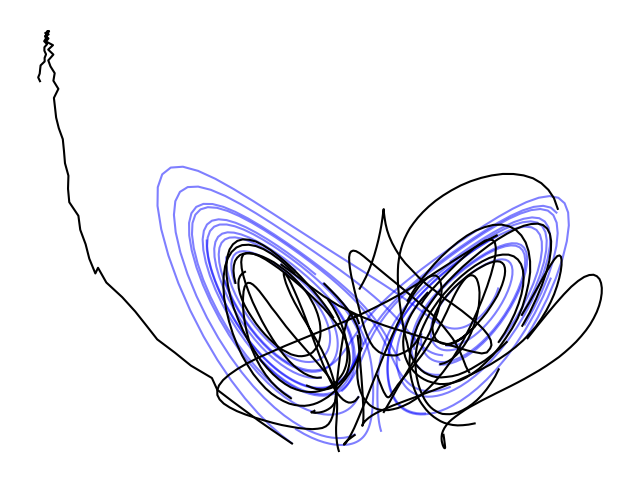

In [40]:


plt.figure(figsize=(8, 6))
plt.plot(traj_test_forecast[..., 0].T, traj_test_forecast[..., 2].T, color='blue', alpha=0.4)
for traj in all_traj_forecasts:
    plt.plot(traj[:, 0], traj[:, 2], color="k", alpha=0.1)
plt.xlim(np.min(traj_test_forecast[..., 0]), np.max(traj_test_forecast[..., 0]))
plt.ylim(np.min(traj_test_forecast[..., 2]), np.max(traj_test_forecast[..., 2]))
plt.axis('off');


plt.figure(figsize=(8, 6))
plt.plot(traj_test_forecast[..., 0].T, traj_test_forecast[..., 2].T, "b", alpha=0.5);
# plt.plot(ic_test[:, 0], ic_test[:, 2], "o");
# plt.plot(all_traj_forecasts[..., 0].T, all_traj_forecasts[..., 2].T, "k");

all_forecasts_ave = np.mean(all_traj_forecasts, axis=-1)
plt.plot(all_forecasts_ave[:, :, 0].T, all_forecasts_ave[:, :, 2].T, "k");
plt.axis('off');


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/3614755201.py:6: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/3614755201.py:12: RuntimeWarning: All-NaN slice encountered
  plt.plot(np.nanmedian(all_smape_rolling, axis=(0, 1)))


Text(0.5, 1.0, 'SMAPE for Lorenz forecast with large model')

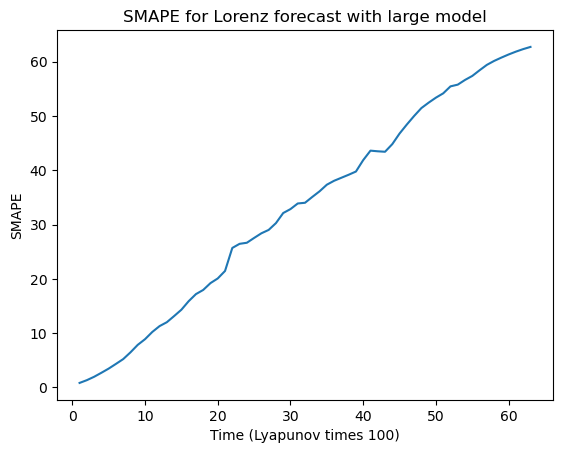

In [41]:
all_smape_rolling = list()

for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
    all_smape = list()
    for i in range(traj_pred.shape[1]):
        smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
        # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
        all_smape.append(smape_val)
    all_smape_rolling.append(all_smape)
all_smape_rolling = np.array(all_smape_rolling)

plt.plot(np.nanmedian(all_smape_rolling, axis=(0, 1)))
plt.xlabel("Time (Lyapunov times 100)")
plt.ylabel("SMAPE")
plt.title(f"SMAPE for {equation_name} forecast with {model_size} model")

# Properties across many models

In [56]:
from dysts.base import get_attractor_list

model_sizes = ["tiny", "mini", "small", "base", "large"]
all_traces  = dict()

# for model_size in model_sizes:
#     all_traces[model_size] = list()

equation_names = get_attractor_list()
for equation_name in equation_names:
    
    all_traces[equation_name] = dict()
    for model_size in model_sizes:
        try:
            traj_test_forecast = np.load(f"./zero-shot/forecast_{equation_name}_true_chronos.npy", allow_pickle=True)
            all_traj_forecasts = np.load(
                f"./zero-shot/forecast_{equation_name}_chronos-{model_size}-context100.npy", allow_pickle=True
            )
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            all_traces.pop(equation_name, None)
            continue
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
                # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)

        all_traces[equation_name][model_size] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)


/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/2848330276.py:30: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/2848330276.py:36: RuntimeWarning: Mean of empty slice
  all_traces[equation_name][model_size] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_58914/2848330276.py:36: RuntimeWarning: All-NaN slice encountered
  all_trac

Skipping ArnoldWeb tiny
Skipping ArnoldWeb mini
Skipping ArnoldWeb small
Skipping ArnoldWeb base
Skipping ArnoldWeb large
Skipping BickleyJet tiny
Skipping BickleyJet mini
Skipping BickleyJet small
Skipping BickleyJet base
Skipping BickleyJet large
Skipping Blasius tiny
Skipping Blasius mini
Skipping Blasius small
Skipping Blasius base
Skipping Blasius large
Skipping BlinkingRotlet tiny
Skipping BlinkingRotlet mini
Skipping BlinkingRotlet small
Skipping BlinkingRotlet base
Skipping BlinkingRotlet large
Skipping BlinkingVortex tiny
Skipping BlinkingVortex mini
Skipping BlinkingVortex small
Skipping BlinkingVortex base
Skipping BlinkingVortex large
Skipping Bouali tiny
Skipping Bouali mini
Skipping Bouali small
Skipping Bouali base
Skipping Bouali large
Skipping BurkeShaw tiny
Skipping BurkeShaw mini
Skipping BurkeShaw small
Skipping BurkeShaw base
Skipping BurkeShaw large
Skipping CaTwoPlus tiny
Skipping CaTwoPlus mini
Skipping CaTwoPlus small
Skipping CaTwoPlus base
Skipping CaTwoPlus 

#### Plot forecast results averaged across models

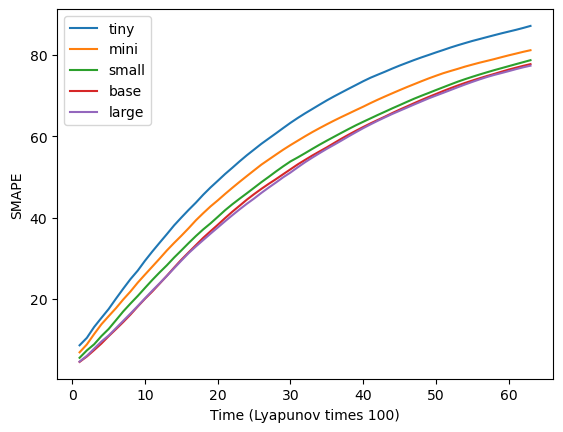

In [85]:

all_all_vals = list()

for model_size in all_traces["Lorenz"].keys():
    all_vals = list()
    for equation_name in all_traces.keys():
        vals = all_traces[equation_name][model_size]
        all_vals.append(vals)
    all_all_vals.append(np.array(all_vals))
all_all_vals = np.array(all_all_vals)


# import degas as dg
for i, model_size in enumerate(model_sizes):
    mv_vals = np.mean(all_all_vals, axis=1)[i]
    std_vals = np.std(all_all_vals, axis=1)[i]
    plt.plot(mv_vals, label=model_size)

    plt.xlabel("Time (Lyapunov times 100)")
    plt.ylabel("SMAPE")
plt.legend()


### Correlation between forecast and invariant properties of different dynamical systems

In [86]:

## Load the invariant properties for each individual system
import dysts.flows as dfl
all_lyap = list()
all_corrdim = list()
all_acc = list()
for equation_name in all_traces:
    all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)

    # spec = np.array(getattr(dfl, equation_name)().lyapunov_spectrum_estimated)
    # try:
    #     all_lyap.append(np.sum(spec[spec > 0]))
    # except:
    #     all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    all_corrdim.append(getattr(dfl, equation_name)().correlation_dimension)
    all_acc.append(all_traces[equation_name]["mini"][6])

Text(0, 0.5, 'Correlation with Lyapunov Exponent')

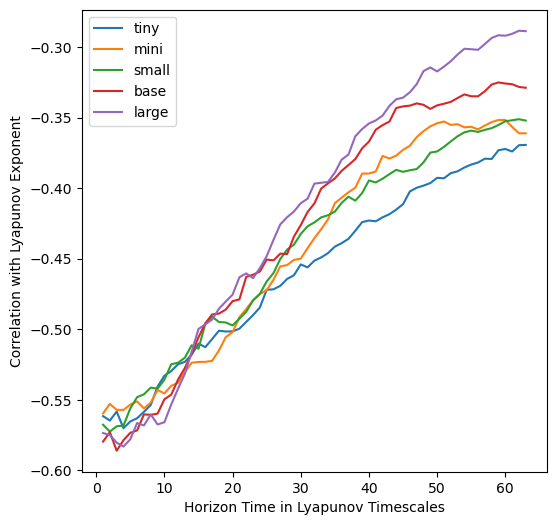

In [90]:
from scipy.stats import spearmanr

## Load the invariant properties for each individual system
plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_lyap = list()
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_lyap, all_acc).correlation
        all_corr_lyap.append(corr)
        corr = spearmanr(all_corrdim, all_acc).correlation
        all_corr_corrdim.append(corr)
    plt.plot(all_corr_lyap, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Lyapunov Exponent")

# plt.plot(all_corr_corrdim)

# In-context learning experiments

+ Titrate the number of forecasts, see how predictions improve
+ Collect 50-100 samples from attractor, but don't reset the model between them